In [1]:
import gym
import numpy as np
from tqdm import tqdm
import random

import matplotlib.pyplot as plt

## Крестики-нолики при помощи Q-обучения

Уже реализованное окружение для крестиков-ноликов.

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3


class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def _check_terminal(self, cur_p):
        cur_marks = np.where(self.board == cur_p)
        for i,j in zip(cur_marks[0], cur_marks[1]):
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    return True
            if j <= self.n_cols - self.n_win:
                if np.all(self.board[i,j:j+self.n_win] == cur_p):
                    return True
            if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                    return True
            if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                    return True
        return False
    
    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_win = self._check_terminal(self.curTurn)
        if cur_win:
                self.gameOver = True
                return self.curTurn
            
        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def getWinner(self):
        # фактически запускаем isTerminal два раза для крестиков и ноликов
        if self._check_terminal(1):
            return 1
        if self._check_terminal(-1):
            return -1
        if len(self.getEmptySpaces()) == 0:
            return 0
        return None
    
    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

Оптимальные параметры для Q-learning

In [3]:
ALPHA = 0.15
EPSILON = 0.2
GAMMA = 0.95

In [4]:
def pick_action(pi, state, empty_spaces, eps):
    move = np.random.randint(len(empty_spaces))
    if state in pi:
        if random.random() > eps:
            move = np.argmax(pi[state])
    else:
        pi[state] = np.zeros(len(empty_spaces))
    return move, empty_spaces[move]


def Q_learning(pi_crosses, pi_naughts, alpha, epsilon, gamma):
    env.reset()
    s, empty_spaces, turn = env.getState()
    done = False
    crosses_state,  crosses_action = None, None
    naughts_state, naughts_action = None, None

    while not done:
        if turn == 1:
            pi = pi_crosses
            pi_rival = pi_naughts
            state = crosses_state
            action = crosses_action
            state_rival = naughts_state
            action_rival = naughts_action
            needed_reward = 1
        if turn == -1:
            pi = pi_naughts
            pi_rival = pi_crosses
            state = naughts_state
            action = naughts_action
            state_rival = crosses_state
            action_rival = crosses_action
            needed_reward = -1

        move, move_aсtion = pick_action(pi, s, empty_spaces, eps=epsilon)
        new_state, reward, done, _ = env.step(move_aсtion)
        if reward == needed_reward:
            pi[s][move] = 1
        if state_rival:
            max_pi = np.max(pi_rival.get(new_state[0], 0))
            pi_rival[state_rival][action_rival] = pi_rival[state_rival][action_rival] +\
            alpha * (- needed_reward * reward + gamma *  max_pi -  pi_rival[state_rival][action_rival])
            
        if turn == 1:
            crosses_state, crosses_action = s, move
        if turn == -1:
            naughts_state, naughts_action = s, move
            
        s, empty_spaces, turn = new_state

def one_episode(pi_crosses, pi_naughts, game_type):
    env.reset()
    s, empty_spaces, turn = env.getState()
    done = False
    while not done:
        pi = pi_crosses if game_type == 1 else pi_naughts
        eps = 0 if game_type == turn else 1
        move, move_aсtion = pick_action(pi, s, empty_spaces, eps=eps)
        state, reward, done, _ = env.step(move_aсtion)
        s, empty_spaces, turn = state
    return reward


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 10))
    plt.plot(x, y)
    plt.xlabel("Number of games")
    plt.ylabel("Frequency of win")
    plt.title(title)
    plt.show()

In [5]:
def check_stats(pi_crosses, pi_naughts, n_games_stat):
    naughts_stat, crosses_stat = [], []
    for _ in range(n_games_stat):
        naughts_stat.append(one_episode(pi_crosses, pi_naughts, game_type=-1))
        crosses_stat.append(one_episode(pi_crosses, pi_naughts, game_type=1))
    return naughts_stat.count(-1) / n_games_stat, crosses_stat.count(1) / n_games_stat


def train(alpha, epsilon, gamma, n_iterations, iteration_check_stat, n_games_stat):
    pi_crosses, pi_naughts = {}, {}
    naughts_stat, crosses_stat = [], []

    for i in tqdm(range(n_iterations)):
        Q_learning(pi_crosses, pi_naughts, alpha=alpha, epsilon=epsilon, gamma=gamma)
        if i % iteration_check_stat == 0:
            naughts_stat_curr, crosses_stat_curr = check_stats(pi_crosses, pi_naughts, n_games_stat)
            naughts_stat.append(naughts_stat_curr)
            crosses_stat.append(crosses_stat_curr)           
            x_range.append(i)
            
    return naughts_stat, crosses_stat



### Доска 3х3

100%|█████████████████████████████████| 100000/100000 [01:30<00:00, 1110.86it/s]


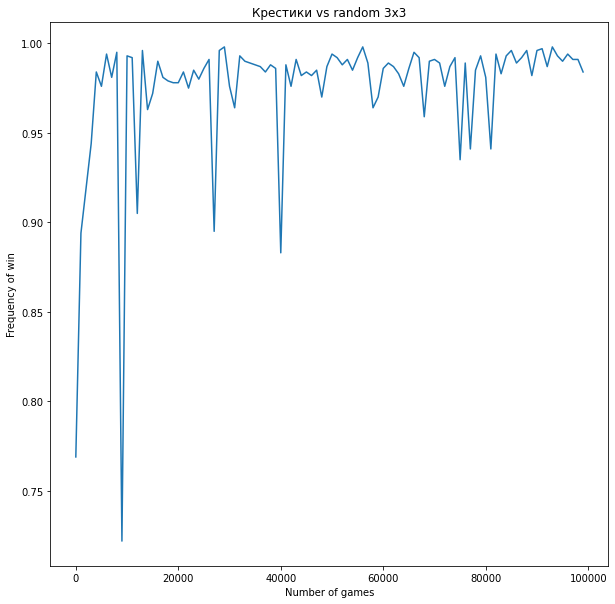

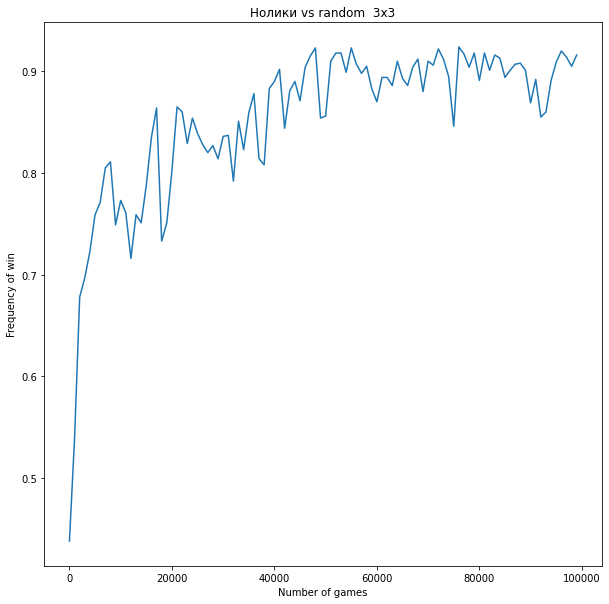

In [6]:
alpha = 0.05
epsilon = 0.7
gamma = 0.95


env = TicTacToe(3, 3, 3)
x_range = []

naughts_stat, crosses_stat = train(
    alpha=ALPHA,
    epsilon=EPSILON,
    gamma=GAMMA,
    n_iterations=100_000,
    iteration_check_stat=1_000,
    n_games_stat=1000,
)


plot_stats(x_range, crosses_stat, "Крестики vs random 3x3")
plot_stats(x_range, naughts_stat, "Нолики vs random  3x3")

Видим, что крестики выучились довольно хорошо - очень близко к 100%. Нолики - чуть похуже.

## DQN